Using data directory: /mnt/c/Users/ASUS/Desktop/landslide4sense trail/pred_map/landslide_data
Processing LANDSAT/LC08/C02/T1_L2 as an ImageCollection with time range 2011-01-01 to 2023-12-31.
Export task started for /mnt/c/Users/ASUS/Desktop/landslide4sense trail/pred_map/landslide_data/blue.tif...
Processing LANDSAT/LC08/C02/T1_L2 as an ImageCollection with time range 2011-01-01 to 2023-12-31.
Export task started for /mnt/c/Users/ASUS/Desktop/landslide4sense trail/pred_map/landslide_data/green.tif...
Processing LANDSAT/LC08/C02/T1_L2 as an ImageCollection with time range 2011-01-01 to 2023-12-31.
Export task started for /mnt/c/Users/ASUS/Desktop/landslide4sense trail/pred_map/landslide_data/red.tif...
Processing LANDSAT/LC08/C02/T1_L2 as an ImageCollection with time range 2011-01-01 to 2023-12-31.
Export task started for /mnt/c/Users/ASUS/Desktop/landslide4sense trail/pred_map/landslide_data/nir.tif...
Processing LANDSAT/LC08/C02/T1_L2 as an ImageCollection with time range 2011-01-01 

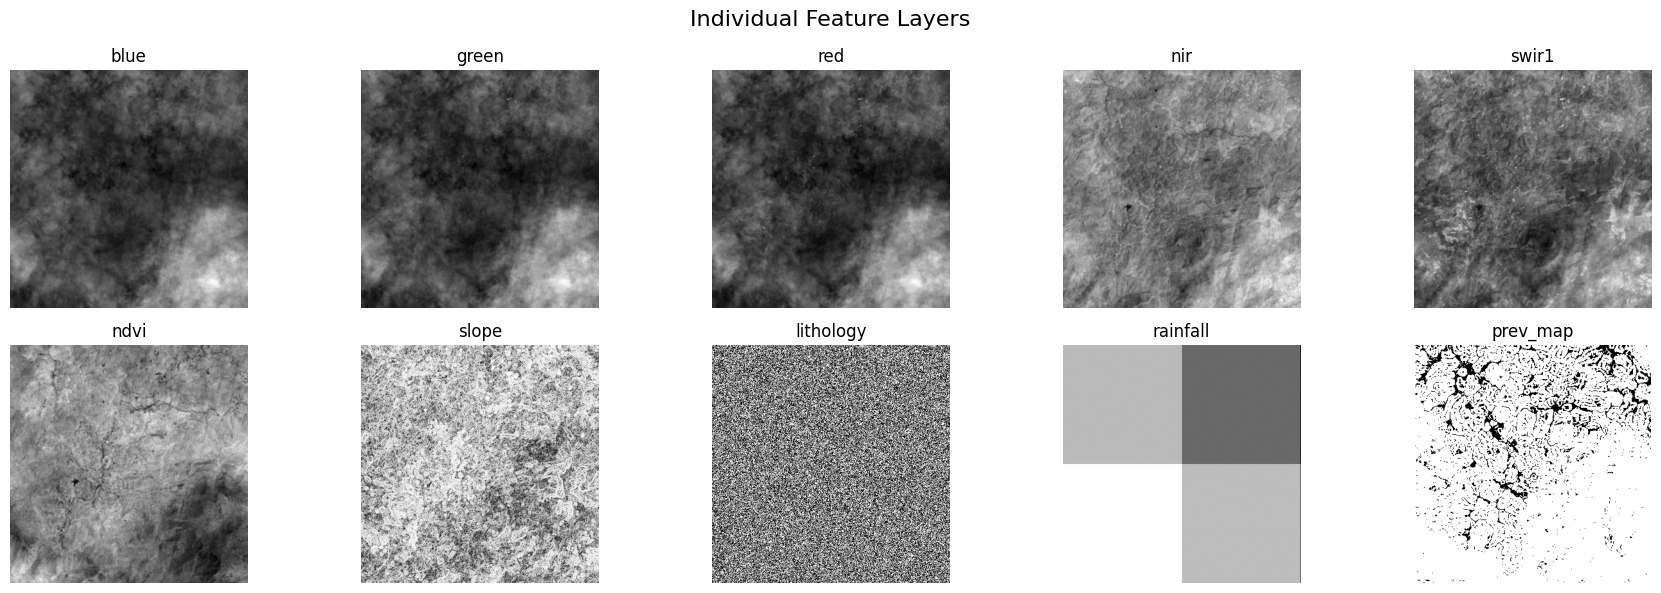

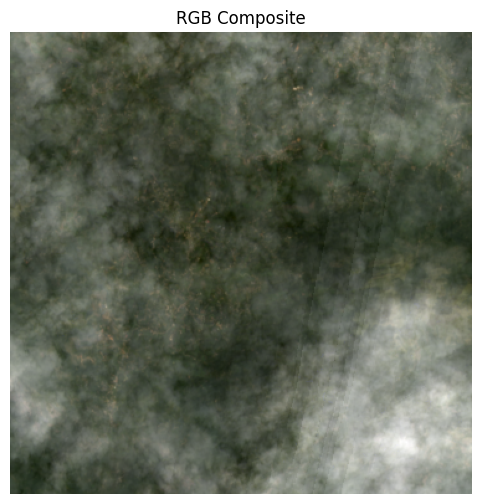

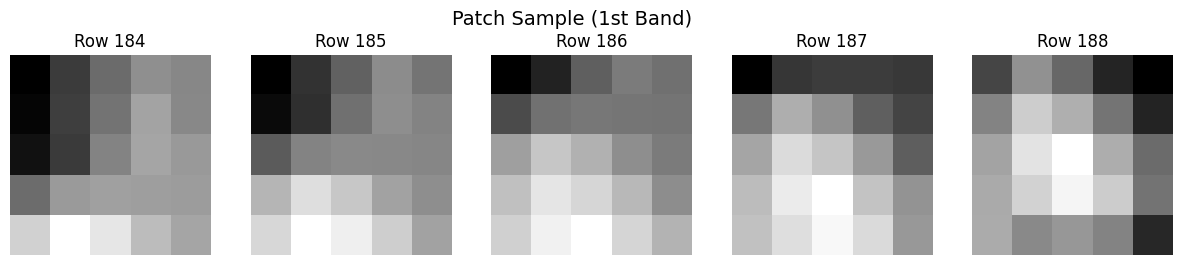

In [ ]:
import ee
import numpy as np
import rasterio
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import os
from datetime import datetime
import time

# Authenticate and Initialize Google Earth Engine
ee.Authenticate()
try:
    ee.Initialize()
except Exception as e:
    print(f"Error initializing GEE: {e}")
    print("Run 'earthengine authenticate' and follow the prompts.")
    exit()

# Define study area: Western Ghats near Wayanad, Kerala (10km x 10km)
region = ee.Geometry.Rectangle([76.0, 11.5, 76.1, 11.6])
resolution = 30  # 30m resolution for Landsat data

# Function to mask clouds in Landsat 8 imagery using QA_PIXEL band
def mask_landsat_clouds(image):
    qa = image.select('QA_PIXEL')
    cloud_bit = 1 << 3  # Bit 3 for cloud
    cloud_shadow_bit = 1 << 4  # Bit 4 for cloud shadow
    mask = qa.bitwiseAnd(cloud_bit).eq(0).And(qa.bitwiseAnd(cloud_shadow_bit).eq(0))
    return image.updateMask(mask)

# Function to download raster data, handling both Image and ImageCollection
def download_raster(collection, bands, start_date, end_date, region, scale, output_path, is_image=False, apply_cloud_mask=False):
    if is_image:
        print(f"Processing {collection} as a static Image (not a collection).")
        image = ee.Image(collection)
        if isinstance(bands, list):
            image = image.select(bands)
        else:
            image = image.select(bands)
        image = image.clip(region)
    else:
        print(f"Processing {collection} as an ImageCollection with time range {start_date} to {end_date}.")
        image_coll = (ee.ImageCollection(collection)
                      .filterBounds(region)
                      .filterDate(start_date, end_date))
        if apply_cloud_mask:
            image_coll = image_coll.map(mask_landsat_clouds)
        image = image_coll.mean()
        if isinstance(bands, list):
            image = image.select(bands)
        else:
            image = image.select(bands)
        image = image.clip(region)
    
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=os.path.basename(output_path),
        folder='landslide_data',
        region=region,
        scale=scale,
        fileFormat='GeoTIFF'
    )
    task.start()
    print(f"Export task started for {output_path}...")
    return task

# Set data directory to the specified path (mapped in WSL)
data_dir = '/mnt/c/Users/ASUS/Desktop/landslide4sense trail/pred_map/landslide_data'
os.makedirs(data_dir, exist_ok=True)
print(f"Using data directory: {data_dir}")

# Download multispectral bands and other data for 2021-2023 with cloud masking
start_date = '2011-01-01'
end_date = '2023-12-31'  # Three-year dataset
landsat_bands = {
    'SR_B2': 'blue.tif',  # Blue
    'SR_B3': 'green.tif', # Green
    'SR_B4': 'red.tif',   # Red
    'SR_B5': 'nir.tif',   # NIR
    'SR_B6': 'swir1.tif'  # SWIR1
}
tasks = []
for band, filename in landsat_bands.items():
    task = download_raster('LANDSAT/LC08/C02/T1_L2', band, start_date, end_date, region, resolution, os.path.join(data_dir, filename), is_image=False, apply_cloud_mask=True)
    tasks.append((task, filename))

# Download DEM (SRTM) as a static image
task = download_raster('USGS/SRTMGL1_003', 'elevation', start_date, end_date, region, resolution, os.path.join(data_dir, 'elevation.tif'), is_image=True)
tasks.append((task, 'elevation.tif'))

# Download rainfall data (CHIRPS) for three years
task = download_raster('UCSB-CHG/CHIRPS/DAILY', 'precipitation', start_date, end_date, region, resolution, os.path.join(data_dir, 'rainfall.tif'), is_image=False)
tasks.append((task, 'rainfall.tif'))

# Manual pause to ensure files are downloaded from Google Drive
print("\nIMPORTANT: GEE export tasks have been started. Please follow these steps:")
print("1. Go to https://code.earthengine.google.com/ and check the 'Tasks' tab for export completion.")
print("2. Once tasks are completed, download all GeoTIFF files from Google Drive's 'landslide_data' folder.")
print("3. Place the files in the specified directory:", os.path.abspath(data_dir))
print("Files needed: blue.tif, green.tif, red.tif, nir.tif, swir1.tif, elevation.tif, rainfall.tif")
input("Press Enter to continue after downloading and placing all files in the specified folder...")

# Verify that all files exist before proceeding
required_files = ['blue.tif', 'green.tif', 'red.tif', 'nir.tif', 'swir1.tif', 'elevation.tif', 'rainfall.tif']
missing_files = []
for file in required_files:
    if not os.path.exists(os.path.join(data_dir, file)):
        missing_files.append(file)

if missing_files:
    print(f"Error: The following files are missing in {data_dir}: {', '.join(missing_files)}")
    print("Please download them from Google Drive and place them in the correct folder before proceeding.")
    exit(1)
else:
    print("All required files are present. Proceeding with processing...")

# Load all rasters with error handling and shape checking
rasters = {}
try:
    for key in ['blue', 'green', 'red', 'nir', 'swir1', 'elevation', 'rainfall']:
        rasters[key] = rasterio.open(os.path.join(data_dir, f"{key}.tif")).read(1)
except rasterio.errors.RasterioIOError as e:
    print(f"Error: Could not load raster files. {e}")
    print("Ensure all required GeoTIFF files are downloaded correctly.")
    exit(1)

# Check shapes of loaded rasters and set reference shape
reference_shape = None
for key, raster in rasters.items():
    if reference_shape is None:
        reference_shape = raster.shape
        print(f"Reference shape set to {reference_shape} from {key}.tif")
    elif raster.shape != reference_shape:
        print(f"Shape mismatch: {key}.tif has shape {raster.shape}, expected {reference_shape}")
        print(f"Warning: Shape mismatch detected. Manual alignment needed or adjust script for resampling.")
        exit(1)
    else:
        print(f"Shape match: {key}.tif has shape {raster.shape}")

# Since shapes are verified, proceed with derived rasters
# Calculate NDVI locally with error handling
def calculate_ndvi(nir_path, red_path, output_path):
    try:
        with rasterio.open(nir_path) as nir, rasterio.open(red_path) as red:
            nir_band = nir.read(1).astype(float)
            red_band = red.read(1).astype(float)
            np.seterr(divide='ignore', invalid='ignore')
            ndvi = (nir_band - red_band) / (nir_band + red_band)
            ndvi = np.nan_to_num(ndvi, nan=0.0)
            with rasterio.open(output_path, 'w', driver='GTiff', height=nir.height, width=nir.width, count=1, dtype='float32', crs=nir.crs, transform=nir.transform) as dst:
                dst.write(ndvi, 1)
        return ndvi
    except rasterio.errors.RasterioIOError as e:
        print(f"Error: Could not open input files for NDVI calculation. {e}")
        print(f"Ensure {nir_path} and {red_path} are downloaded correctly.")
        exit(1)

ndvi = calculate_ndvi(os.path.join(data_dir, 'nir.tif'), os.path.join(data_dir, 'red.tif'), os.path.join(data_dir, 'ndvi.tif'))

# Calculate slope locally from elevation with error handling
def calculate_slope(elevation_path, output_path):
    try:
        with rasterio.open(elevation_path) as src:
            elevation = src.read(1)
            dx, dy = np.gradient(elevation, resolution)
            slope = np.degrees(np.arctan(np.sqrt(dx**2 + dy**2)))
            with rasterio.open(output_path, 'w', driver='GTiff', height=src.height, width=src.width, count=1, dtype='float32', crs=src.crs, transform=src.transform) as dst:
                dst.write(slope, 1)
        return slope
    except rasterio.errors.RasterioIOError as e:
        print(f"Error: Could not open elevation file for slope calculation. {e}")
        print(f"Ensure {elevation_path} is downloaded correctly.")
        exit(1)

slope = calculate_slope(os.path.join(data_dir, 'elevation.tif'), os.path.join(data_dir, 'slope.tif'))

# Load derived rasters
try:
    rasters['ndvi'] = rasterio.open(os.path.join(data_dir, 'ndvi.tif')).read(1)
    rasters['slope'] = rasterio.open(os.path.join(data_dir, 'slope.tif')).read(1)
except rasterio.errors.RasterioIOError as e:
    print(f"Error: Could not load derived raster files. {e}")
    print("Ensure derived files are created correctly.")
    exit(1)

# Verify shapes for derived rasters
for key, raster in rasters.items():
    if raster.shape != reference_shape:
        print(f"Shape mismatch after derived rasters: {key} has shape {raster.shape}, expected {reference_shape}")
        print(f"Warning: Shape mismatch detected. Manual alignment needed or adjust script for resampling.")
        exit(1)
    else:
        print(f"Shape match: {key} has shape {raster.shape}")

# Create synthetic lithology and previous landslide map with dynamic shape based on reference
np.random.seed(42)
height, width = reference_shape  # Use reference shape from GEE rasters
synthetic_lithology = np.random.randint(1, 5, (height, width))
#synthetic_prev_map = np.random.choice([0, 1], size=(height, width), p=[0.8, 0.2])
with rasterio.open(os.path.join(data_dir, 'lithology.tif'), 'w', driver='GTiff', height=height, width=width, count=1, dtype='int32', crs='EPSG:4326', transform=rasterio.transform.from_bounds(76.0, 11.5, 76.1, 11.6, width, height)) as dst:
    dst.write(synthetic_lithology, 1)
#with rasterio.open(os.path.join(data_dir, 'prev_map.tif'), 'w', driver='GTiff', height=height, width=width, count=1, dtype='int32', crs='EPSG:4326', transform=rasterio.transform.from_bounds(76.0, 11.5, 76.1, 11.6, width, height)) as dst:
#    dst.write(synthetic_prev_map, 1)

# Load synthetic data into rasters dictionary
try:
    rasters['lithology'] = rasterio.open(os.path.join(data_dir, 'lithology.tif')).read(1)
    rasters['prev_map'] = rasterio.open(os.path.join(data_dir, 'prev_map.tif')).read(1)
except rasterio.errors.RasterioIOError as e:
    print(f"Error: Could not load synthetic raster files. {e}")
    print("Ensure synthetic files are created correctly.")
    exit(1)

# Verify shapes for synthetic rasters
for key, raster in rasters.items():
    if raster.shape != reference_shape:
        print(f"Shape mismatch for synthetic rasters: {key} has shape {raster.shape}, expected {reference_shape}")
        print(f"Warning: Shape mismatch detected. Manual alignment needed or adjust script for resampling.")
        exit(1)
    else:
        print(f"Shape match: {key} has shape {raster.shape}")



def visualize_feature_stack(rasters, patch_size=5, show_patch=True, show_rgb=True):
    import matplotlib.pyplot as plt

    # Define some features to display
    feature_keys = ['blue', 'green', 'red', 'nir', 'swir1', 'ndvi', 'slope', 'lithology', 'rainfall','prev_map']
    n_features = len(feature_keys)

    # Plot each feature band
    fig, axes = plt.subplots(2, (n_features + 1) // 2, figsize=(18, 6))
    fig.suptitle("Individual Feature Layers", fontsize=16)

    for ax, key in zip(axes.flat, feature_keys):
        img = rasters[key]
        ax.imshow(img, cmap='gray')
        ax.set_title(key)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    # Optional: RGB composite using red, green, blue
    if show_rgb and all(k in rasters for k in ['red', 'green', 'blue']):
        rgb = np.stack([
            rasters['red'],
            rasters['green'],
            rasters['blue']
        ], axis=-1)
        rgb_norm = (rgb - rgb.min()) / (rgb.max() - rgb.min())  # Normalize
        plt.figure(figsize=(6, 6))
        plt.imshow(rgb_norm)
        plt.title("RGB Composite")
        plt.axis('off')
        plt.show()

    # Optional: Show example patch (center of image)
    if show_patch:
        h, w = rasters['ndvi'].shape
        i, j = h // 2, w // 2
        half = patch_size // 2
        fig, axes = plt.subplots(1, patch_size, figsize=(15, 3))
        for k in range(patch_size):
            i_idx = i - half + k
            patch_row = []
            for key in feature_keys:
                band = rasters[key]
                patch = band[i_idx-half:i_idx+half+1, j-half:j+half+1]
                patch_row.append(patch)
            stacked_patch = np.stack(patch_row, axis=-1)
            axes[k].imshow(stacked_patch[:, :, 0], cmap='gray')  # Show first band as preview
            axes[k].set_title(f"Row {i_idx}")
            axes[k].axis('off')
        plt.suptitle("Patch Sample (1st Band)", fontsize=14)
        plt.show()



visualize_feature_stack(rasters)

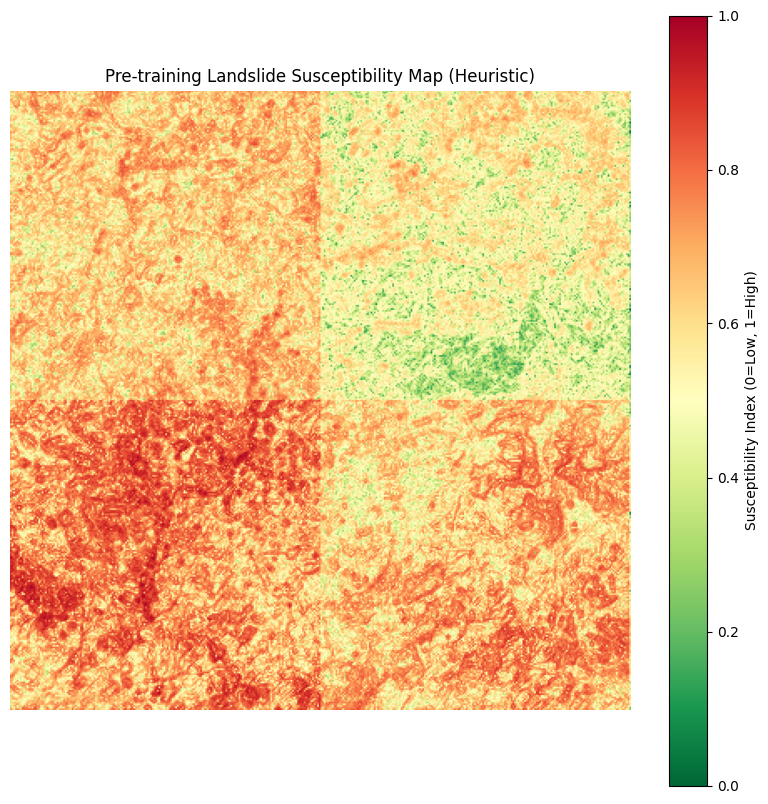

ValueError: Found input variables with inconsistent numbers of samples: [138384, 136157]

In [ ]:
def generate_pretraining_susceptibility_map(rasters, output_path=None, show=True):
    """
    Create a heuristic-based landslide susceptibility map using raw features before model training.
    
    rasters: dict containing raw feature arrays, keys must include: 'slope', 'rainfall', 'ndvi', 'lithology'
    output_path: optional file path to save PNG
    show: if True, displays the plot inline
    """
    slope = rasters['slope'].astype(float)
    rainfall = rasters['rainfall'].astype(float)
    ndvi = rasters['ndvi'].astype(float)
    lithology = rasters['lithology'].astype(int)

    # Normalize continuous variables (0–1)
    slope_norm = (slope - slope.min()) / (slope.max() - slope.min())
    rainfall_norm = (rainfall - rainfall.min()) / (rainfall.max() - rainfall.min())
    ndvi_norm = (ndvi - ndvi.min()) / (ndvi.max() - ndvi.min())

    # Invert NDVI (low vegetation = high susceptibility)
    inv_ndvi = 1.0 - ndvi_norm

    # Lithology scoring (example: user-defined risk per class)
    lithology_score = np.zeros_like(lithology, dtype=float)
    lithology_weights = {
        1: 0.6,  # e.g., hard rock = low risk
        2: 0.7,
        3: 0.9,
        4: 1.0   # e.g., weak soil = high risk
    }
    for val, score in lithology_weights.items():
        lithology_score[lithology == val] = score

    # Combine all into a simple susceptibility index (weighted sum)
    susceptibility = (
        0.4 * slope_norm +
        0.3 * rainfall_norm +
        0.2 * inv_ndvi +
        0.1 * lithology_score
    )

    # Normalize the final result to 0–1
    susceptibility = (susceptibility - susceptibility.min()) / (susceptibility.max() - susceptibility.min())

    # Plot the map
    plt.figure(figsize=(10, 10))
    cmap = plt.cm.RdYlGn_r  # Red = high risk
    im = plt.imshow(susceptibility, cmap=cmap, vmin=0, vmax=1)
    plt.colorbar(im, label='Susceptibility Index (0=Low, 1=High)')
    plt.title('Pre-training Landslide Susceptibility Map (Heuristic)')
    plt.axis('off')

    if output_path:
        plt.savefig(output_path, bbox_inches='tight', dpi=300)
    if show:
        plt.show()
    else:
        plt.close()

    return susceptibility

heuristic_map = generate_pretraining_susceptibility_map(rasters, output_path='heuristic_susceptibility.png')


# Prepare data for CNN with spatial patches
patch_size = 5  # 5x5 patches
half_patch = patch_size // 2
height, width = rasters['ndvi'].shape
n_features = len(rasters) - 1  # Exclude prev_map (target)
X = np.zeros((height * width, patch_size, patch_size, n_features))
y = rasters['prev_map'].flatten()

feature_stack = np.stack([rasters[key] for key in rasters if key != 'prev_map'], axis=-1)
idx = 0
for i in range(height):
    for j in range(width):
        i_start = max(0, i - half_patch)
        i_end = min(height, i + half_patch + 1)
        j_start = max(0, j - half_patch)
        j_end = min(width, j + half_patch + 1)
        patch = feature_stack[i_start:i_end, j_start:j_end, :]
        pad_i = half_patch - (i - i_start)
        pad_i_end = half_patch + 1 + (i_end - i - 1)
        pad_j = half_patch - (j - j_start)
        pad_j_end = half_patch + 1 + (j_end - j - 1)
        padded_patch = np.zeros((patch_size, patch_size, n_features))
        padded_patch[pad_i:pad_i_end, pad_j:pad_j_end, :] = patch
        X[idx] = padded_patch
        idx += 1

# Normalize features
scaler = StandardScaler()
X_reshaped = X.reshape(-1, n_features)
X_reshaped = scaler.fit_transform(X_reshaped)
X = X_reshaped.reshape(X.shape)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build optimized CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(patch_size, patch_size, n_features), padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train model
history = model.fit(X_train, y_train, epochs=35, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Predict susceptibility for entire area
predictions = model.predict(X).reshape(height, width)

In [ ]:
# Create color-coded map
plt.figure(figsize=(10, 10))
cmap = plt.cm.RdYlGn_r
plt.imshow(predictions, cmap=cmap, vmin=0, vmax=1)
plt.colorbar(label='Landslide Susceptibility (0=Low, 1=High)')
plt.title('Baseline Landslide Susceptibility Map for Western Ghats, Kerala (Next Few Years)')
plt.savefig('landslide_susceptibility_map_kerala.png')
plt.close()

# Save model
model.save('landslide_model_kerala.h5')

# Clean up temporary files
#try:
#   for file in os.listdir(data_dir):
#      os.remove(os.path.join(data_dir, file))
#        os.rmdir(data_dir)
#except Exception as e:
#    print(f"Error cleaning up temporary files: {e}")

print("Model and map saved. Check 'landslide_model_kerala.h5' and 'landslide_susceptibility_map_kerala.png'.")

: 

In [ ]:
import ee
import numpy as np
import rasterio
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import os
from datetime import datetime
import time

# Authenticate and Initialize Google Earth Engine
ee.Authenticate()
try:
    ee.Initialize()
except Exception as e:
    print(f"Error initializing GEE: {e}")
    print("Run 'earthengine authenticate' and follow the prompts.")
    exit()

# Define study area: Western Ghats near Wayanad, Kerala (10km x 10km)
region = ee.Geometry.Rectangle([76.0, 11.5, 76.1, 11.6])
resolution = 30  # 30m resolution for Landsat data

# Function to mask clouds in Landsat 8 imagery using QA_PIXEL band
def mask_landsat_clouds(image):
    qa = image.select('QA_PIXEL')
    cloud_bit = 1 << 3  # Bit 3 for cloud
    cloud_shadow_bit = 1 << 4  # Bit 4 for cloud shadow
    mask = qa.bitwiseAnd(cloud_bit).eq(0).And(qa.bitwiseAnd(cloud_shadow_bit).eq(0))
    return image.updateMask(mask)

# Function to download raster data, handling both Image and ImageCollection
def download_raster(collection, bands, start_date, end_date, region, scale, output_path, is_image=False, apply_cloud_mask=False):
    if is_image:
        print(f"Processing {collection} as a static Image (not a collection).")
        image = ee.Image(collection)
        if isinstance(bands, list):
            image = image.select(bands)
        else:
            image = image.select(bands)
        image = image.clip(region)
    else:
        print(f"Processing {collection} as an ImageCollection with time range {start_date} to {end_date}.")
        image_coll = (ee.ImageCollection(collection)
                      .filterBounds(region)
                      .filterDate(start_date, end_date))
        if apply_cloud_mask:
            image_coll = image_coll.map(mask_landsat_clouds)
        image = image_coll.mean()
        if isinstance(bands, list):
            image = image.select(bands)
        else:
            image = image.select(bands)
        image = image.clip(region)
    
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=os.path.basename(output_path),
        folder='landslide_data',
        region=region,
        scale=scale,
        fileFormat='GeoTIFF'
    )
    task.start()
    print(f"Export task started for {output_path}...")
    return task

# Set data directory to the specified path (mapped in WSL)
data_dir = '/mnt/c/Users/ASUS/Desktop/landslide4sense trail/pred_map/landslide_data'
os.makedirs(data_dir, exist_ok=True)
print(f"Using data directory: {data_dir}")

# Download multispectral bands and other data for 2021-2023 with cloud masking
start_date = '2011-01-01'
end_date = '2023-12-31'  # Three-year dataset
landsat_bands = {
    'SR_B2': 'blue.tif',  # Blue
    'SR_B3': 'green.tif', # Green
    'SR_B4': 'red.tif',   # Red
    'SR_B5': 'nir.tif',   # NIR
    'SR_B6': 'swir1.tif'  # SWIR1
}
tasks = []
for band, filename in landsat_bands.items():
    task = download_raster('LANDSAT/LC08/C02/T1_L2', band, start_date, end_date, region, resolution, os.path.join(data_dir, filename), is_image=False, apply_cloud_mask=True)
    tasks.append((task, filename))

# Download DEM (SRTM) as a static image
task = download_raster('USGS/SRTMGL1_003', 'elevation', start_date, end_date, region, resolution, os.path.join(data_dir, 'elevation.tif'), is_image=True)
tasks.append((task, 'elevation.tif'))

# Download rainfall data (CHIRPS) for three years
task = download_raster('UCSB-CHG/CHIRPS/DAILY', 'precipitation', start_date, end_date, region, resolution, os.path.join(data_dir, 'rainfall.tif'), is_image=False)
tasks.append((task, 'rainfall.tif'))

# Manual pause to ensure files are downloaded from Google Drive
print("\nIMPORTANT: GEE export tasks have been started. Please follow these steps:")
print("1. Go to https://code.earthengine.google.com/ and check the 'Tasks' tab for export completion.")
print("2. Once tasks are completed, download all GeoTIFF files from Google Drive's 'landslide_data' folder.")
print("3. Place the files in the specified directory:", os.path.abspath(data_dir))
print("Files needed: blue.tif, green.tif, red.tif, nir.tif, swir1.tif, elevation.tif, rainfall.tif")
input("Press Enter to continue after downloading and placing all files in the specified folder...")

# Verify that all files exist before proceeding
required_files = ['blue.tif', 'green.tif', 'red.tif', 'nir.tif', 'swir1.tif', 'elevation.tif', 'rainfall.tif']
missing_files = []
for file in required_files:
    if not os.path.exists(os.path.join(data_dir, file)):
        missing_files.append(file)

if missing_files:
    print(f"Error: The following files are missing in {data_dir}: {', '.join(missing_files)}")
    print("Please download them from Google Drive and place them in the correct folder before proceeding.")
    exit(1)
else:
    print("All required files are present. Proceeding with processing...")

# Load all rasters with error handling and shape checking
rasters = {}
try:
    for key in ['blue', 'green', 'red', 'nir', 'swir1', 'elevation', 'rainfall']:
        rasters[key] = rasterio.open(os.path.join(data_dir, f"{key}.tif")).read(1)
except rasterio.errors.RasterioIOError as e:
    print(f"Error: Could not load raster files. {e}")
    print("Ensure all required GeoTIFF files are downloaded correctly.")
    exit(1)

# Check shapes of loaded rasters and set reference shape
reference_shape = None
for key, raster in rasters.items():
    if reference_shape is None:
        reference_shape = raster.shape
        print(f"Reference shape set to {reference_shape} from {key}.tif")
    elif raster.shape != reference_shape:
        print(f"Shape mismatch: {key}.tif has shape {raster.shape}, expected {reference_shape}")
        print(f"Warning: Shape mismatch detected. Manual alignment needed or adjust script for resampling.")
        exit(1)
    else:
        print(f"Shape match: {key}.tif has shape {raster.shape}")

# Since shapes are verified, proceed with derived rasters
# Calculate NDVI locally with error handling
def calculate_ndvi(nir_path, red_path, output_path):
    try:
        with rasterio.open(nir_path) as nir, rasterio.open(red_path) as red:
            nir_band = nir.read(1).astype(float)
            red_band = red.read(1).astype(float)
            np.seterr(divide='ignore', invalid='ignore')
            ndvi = (nir_band - red_band) / (nir_band + red_band)
            ndvi = np.nan_to_num(ndvi, nan=0.0)
            with rasterio.open(output_path, 'w', driver='GTiff', height=nir.height, width=nir.width, count=1, dtype='float32', crs=nir.crs, transform=nir.transform) as dst:
                dst.write(ndvi, 1)
        return ndvi
    except rasterio.errors.RasterioIOError as e:
        print(f"Error: Could not open input files for NDVI calculation. {e}")
        print(f"Ensure {nir_path} and {red_path} are downloaded correctly.")
        exit(1)

ndvi = calculate_ndvi(os.path.join(data_dir, 'nir.tif'), os.path.join(data_dir, 'red.tif'), os.path.join(data_dir, 'ndvi.tif'))

# Calculate slope locally from elevation with error handling
def calculate_slope(elevation_path, output_path):
    try:
        with rasterio.open(elevation_path) as src:
            elevation = src.read(1)
            dx, dy = np.gradient(elevation, resolution)
            slope = np.degrees(np.arctan(np.sqrt(dx**2 + dy**2)))
            with rasterio.open(output_path, 'w', driver='GTiff', height=src.height, width=src.width, count=1, dtype='float32', crs=src.crs, transform=src.transform) as dst:
                dst.write(slope, 1)
        return slope
    except rasterio.errors.RasterioIOError as e:
        print(f"Error: Could not open elevation file for slope calculation. {e}")
        print(f"Ensure {elevation_path} is downloaded correctly.")
        exit(1)

slope = calculate_slope(os.path.join(data_dir, 'elevation.tif'), os.path.join(data_dir, 'slope.tif'))

# Load derived rasters
try:
    rasters['ndvi'] = rasterio.open(os.path.join(data_dir, 'ndvi.tif')).read(1)
    rasters['slope'] = rasterio.open(os.path.join(data_dir, 'slope.tif')).read(1)
except rasterio.errors.RasterioIOError as e:
    print(f"Error: Could not load derived raster files. {e}")
    print("Ensure derived files are created correctly.")
    exit(1)

# Verify shapes for derived rasters
for key, raster in rasters.items():
    if raster.shape != reference_shape:
        print(f"Shape mismatch after derived rasters: {key} has shape {raster.shape}, expected {reference_shape}")
        print(f"Warning: Shape mismatch detected. Manual alignment needed or adjust script for resampling.")
        exit(1)
    else:
        print(f"Shape match: {key} has shape {raster.shape}")

# Create synthetic lithology and previous landslide map with dynamic shape based on reference
np.random.seed(42)
height, width = reference_shape  # Use reference shape from GEE rasters
synthetic_lithology = np.random.randint(1, 5, (height, width))
synthetic_prev_map = np.random.choice([0, 1], size=(height, width), p=[0.8, 0.2])
with rasterio.open(os.path.join(data_dir, 'lithology.tif'), 'w', driver='GTiff', height=height, width=width, count=1, dtype='int32', crs='EPSG:4326', transform=rasterio.transform.from_bounds(76.0, 11.5, 76.1, 11.6, width, height)) as dst:
    dst.write(synthetic_lithology, 1)
with rasterio.open(os.path.join(data_dir, 'prev_map.tif'), 'w', driver='GTiff', height=height, width=width, count=1, dtype='int32', crs='EPSG:4326', transform=rasterio.transform.from_bounds(76.0, 11.5, 76.1, 11.6, width, height)) as dst:
    dst.write(synthetic_prev_map, 1)

# Load synthetic data into rasters dictionary
try:
    rasters['lithology'] = rasterio.open(os.path.join(data_dir, 'lithology.tif')).read(1)
    rasters['prev_map'] = rasterio.open(os.path.join(data_dir, 'prev_map.tif')).read(1)
except rasterio.errors.RasterioIOError as e:
    print(f"Error: Could not load synthetic raster files. {e}")
    print("Ensure synthetic files are created correctly.")
    exit(1)

# Verify shapes for synthetic rasters
for key, raster in rasters.items():
    if raster.shape != reference_shape:
        print(f"Shape mismatch for synthetic rasters: {key} has shape {raster.shape}, expected {reference_shape}")
        print(f"Warning: Shape mismatch detected. Manual alignment needed or adjust script for resampling.")
        exit(1)
    else:
        print(f"Shape match: {key} has shape {raster.shape}")



def visualize_feature_stack(rasters, patch_size=5, show_patch=True, show_rgb=True):
    import matplotlib.pyplot as plt

    # Define some features to display
    feature_keys = ['blue', 'green', 'red', 'nir', 'swir1', 'ndvi', 'slope', 'lithology', 'rainfall','prev_map']
    n_features = len(feature_keys)

    # Plot each feature band
    fig, axes = plt.subplots(2, (n_features + 1) // 2, figsize=(18, 6))
    fig.suptitle("Individual Feature Layers", fontsize=16)

    for ax, key in zip(axes.flat, feature_keys):
        img = rasters[key]
        ax.imshow(img, cmap='gray')
        ax.set_title(key)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    # Optional: RGB composite using red, green, blue
    if show_rgb and all(k in rasters for k in ['red', 'green', 'blue']):
        rgb = np.stack([
            rasters['red'],
            rasters['green'],
            rasters['blue']
        ], axis=-1)
        rgb_norm = (rgb - rgb.min()) / (rgb.max() - rgb.min())  # Normalize
        plt.figure(figsize=(6, 6))
        plt.imshow(rgb_norm)
        plt.title("RGB Composite")
        plt.axis('off')
        plt.show()

    # Optional: Show example patch (center of image)
    if show_patch:
        h, w = rasters['ndvi'].shape
        i, j = h // 2, w // 2
        half = patch_size // 2
        fig, axes = plt.subplots(1, patch_size, figsize=(15, 3))
        for k in range(patch_size):
            i_idx = i - half + k
            patch_row = []
            for key in feature_keys:
                band = rasters[key]
                patch = band[i_idx-half:i_idx+half+1, j-half:j+half+1]
                patch_row.append(patch)
            stacked_patch = np.stack(patch_row, axis=-1)
            axes[k].imshow(stacked_patch[:, :, 0], cmap='gray')  # Show first band as preview
            axes[k].set_title(f"Row {i_idx}")
            axes[k].axis('off')
        plt.suptitle("Patch Sample (1st Band)", fontsize=14)
        plt.show()



visualize_feature_stack(rasters)

Using data directory: /mnt/c/Users/ASUS/Desktop/landslide4sense trail/pred_map/landslide_data
Processing LANDSAT/LC08/C02/T1_L2 as an ImageCollection with time range 2011-01-01 to 2023-12-31.
Export task started for /mnt/c/Users/ASUS/Desktop/landslide4sense trail/pred_map/landslide_data/blue.tif...
Processing LANDSAT/LC08/C02/T1_L2 as an ImageCollection with time range 2011-01-01 to 2023-12-31.
Export task started for /mnt/c/Users/ASUS/Desktop/landslide4sense trail/pred_map/landslide_data/green.tif...
Processing LANDSAT/LC08/C02/T1_L2 as an ImageCollection with time range 2011-01-01 to 2023-12-31.
Export task started for /mnt/c/Users/ASUS/Desktop/landslide4sense trail/pred_map/landslide_data/red.tif...
Processing LANDSAT/LC08/C02/T1_L2 as an ImageCollection with time range 2011-01-01 to 2023-12-31.
Export task started for /mnt/c/Users/ASUS/Desktop/landslide4sense trail/pred_map/landslide_data/nir.tif...
Processing LANDSAT/LC08/C02/T1_L2 as an ImageCollection with time range 2011-01-01 

CPLE_AppDefinedError: Deleting /mnt/c/Users/ASUS/Desktop/landslide4sense trail/pred_map/landslide_data/prev_map.tif failed: Permission denied

In [ ]:
def generate_pretraining_susceptibility_map(rasters, output_path=None, show=True):
    """
    Create a heuristic-based landslide susceptibility map using raw features before model training.
    
    rasters: dict containing raw feature arrays, keys must include: 'slope', 'rainfall', 'ndvi', 'lithology'
    output_path: optional file path to save PNG
    show: if True, displays the plot inline
    """
    slope = rasters['slope'].astype(float)
    rainfall = rasters['rainfall'].astype(float)
    ndvi = rasters['ndvi'].astype(float)
    lithology = rasters['lithology'].astype(int)

    # Normalize continuous variables (0–1)
    slope_norm = (slope - slope.min()) / (slope.max() - slope.min())
    rainfall_norm = (rainfall - rainfall.min()) / (rainfall.max() - rainfall.min())
    ndvi_norm = (ndvi - ndvi.min()) / (ndvi.max() - ndvi.min())

    # Invert NDVI (low vegetation = high susceptibility)
    inv_ndvi = 1.0 - ndvi_norm

    # Lithology scoring (example: user-defined risk per class)
    lithology_score = np.zeros_like(lithology, dtype=float)
    lithology_weights = {
        1: 0.6,  # e.g., hard rock = low risk
        2: 0.7,
        3: 0.9,
        4: 1.0   # e.g., weak soil = high risk
    }
    for val, score in lithology_weights.items():
        lithology_score[lithology == val] = score

    # Combine all into a simple susceptibility index (weighted sum)
    susceptibility = (
        0.4 * slope_norm +
        0.3 * rainfall_norm +
        0.2 * inv_ndvi +
        0.1 * lithology_score
    )

    # Normalize the final result to 0–1
    susceptibility = (susceptibility - susceptibility.min()) / (susceptibility.max() - susceptibility.min())

    # Plot the map
    plt.figure(figsize=(10, 10))
    cmap = plt.cm.RdYlGn_r  # Red = high risk
    im = plt.imshow(susceptibility, cmap=cmap, vmin=0, vmax=1)
    plt.colorbar(im, label='Susceptibility Index (0=Low, 1=High)')
    plt.title('Pre-training Landslide Susceptibility Map (Heuristic)')
    plt.axis('off')

    if output_path:
        plt.savefig(output_path, bbox_inches='tight', dpi=300)
    if show:
        plt.show()
    else:
        plt.close()

    return susceptibility

heuristic_map = generate_pretraining_susceptibility_map(rasters, output_path='heuristic_susceptibility.png')


# Prepare data for CNN with spatial patches
patch_size = 5  # 5x5 patches
half_patch = patch_size // 2
height, width = rasters['ndvi'].shape
n_features = len(rasters) - 1  # Exclude prev_map (target)
X = np.zeros((height * width, patch_size, patch_size, n_features))
y = rasters['prev_map'].flatten()

feature_stack = np.stack([rasters[key] for key in rasters if key != 'prev_map'], axis=-1)
idx = 0
for i in range(height):
    for j in range(width):
        i_start = max(0, i - half_patch)
        i_end = min(height, i + half_patch + 1)
        j_start = max(0, j - half_patch)
        j_end = min(width, j + half_patch + 1)
        patch = feature_stack[i_start:i_end, j_start:j_end, :]
        pad_i = half_patch - (i - i_start)
        pad_i_end = half_patch + 1 + (i_end - i - 1)
        pad_j = half_patch - (j - j_start)
        pad_j_end = half_patch + 1 + (j_end - j - 1)
        padded_patch = np.zeros((patch_size, patch_size, n_features))
        padded_patch[pad_i:pad_i_end, pad_j:pad_j_end, :] = patch
        X[idx] = padded_patch
        idx += 1

# Normalize features
scaler = StandardScaler()
X_reshaped = X.reshape(-1, n_features)
X_reshaped = scaler.fit_transform(X_reshaped)
X = X_reshaped.reshape(X.shape)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build optimized CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(patch_size, patch_size, n_features), padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train model
history = model.fit(X_train, y_train, epochs=35, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Predict susceptibility for entire area
predictions = model.predict(X).reshape(height, width)

: 

In [ ]:
# Create color-coded map
plt.figure(figsize=(10, 10))
cmap = plt.cm.RdYlGn_r
plt.imshow(predictions, cmap=cmap, vmin=0, vmax=1)
plt.colorbar(label='Landslide Susceptibility (0=Low, 1=High)')
plt.title('Baseline Landslide Susceptibility Map for Western Ghats, Kerala (Next Few Years)')
plt.savefig('landslide_susceptibility_map_kerala.png')
plt.close()

# Save model
model.save('landslide_model_kerala.h5')

# Clean up temporary files
#try:
#   for file in os.listdir(data_dir):
#      os.remove(os.path.join(data_dir, file))
#        os.rmdir(data_dir)
#except Exception as e:
#    print(f"Error cleaning up temporary files: {e}")

print("Model and map saved. Check 'landslide_model_kerala.h5' and 'landslide_susceptibility_map_kerala.png'.")

: 

Using data directory: /mnt/c/Users/ASUS/Desktop/landslide4sense trail/pred_map/landslide_data
Processing LANDSAT/LC08/C02/T1_L2 as an ImageCollection with time range 2011-01-01 to 2023-12-31.
Export task started for /mnt/c/Users/ASUS/Desktop/landslide4sense trail/pred_map/landslide_data/blue.tif...
Processing LANDSAT/LC08/C02/T1_L2 as an ImageCollection with time range 2011-01-01 to 2023-12-31.
Export task started for /mnt/c/Users/ASUS/Desktop/landslide4sense trail/pred_map/landslide_data/green.tif...
Processing LANDSAT/LC08/C02/T1_L2 as an ImageCollection with time range 2011-01-01 to 2023-12-31.
Export task started for /mnt/c/Users/ASUS/Desktop/landslide4sense trail/pred_map/landslide_data/red.tif...
Processing LANDSAT/LC08/C02/T1_L2 as an ImageCollection with time range 2011-01-01 to 2023-12-31.
Export task started for /mnt/c/Users/ASUS/Desktop/landslide4sense trail/pred_map/landslide_data/nir.tif...
Processing LANDSAT/LC08/C02/T1_L2 as an ImageCollection with time range 2011-01-01 

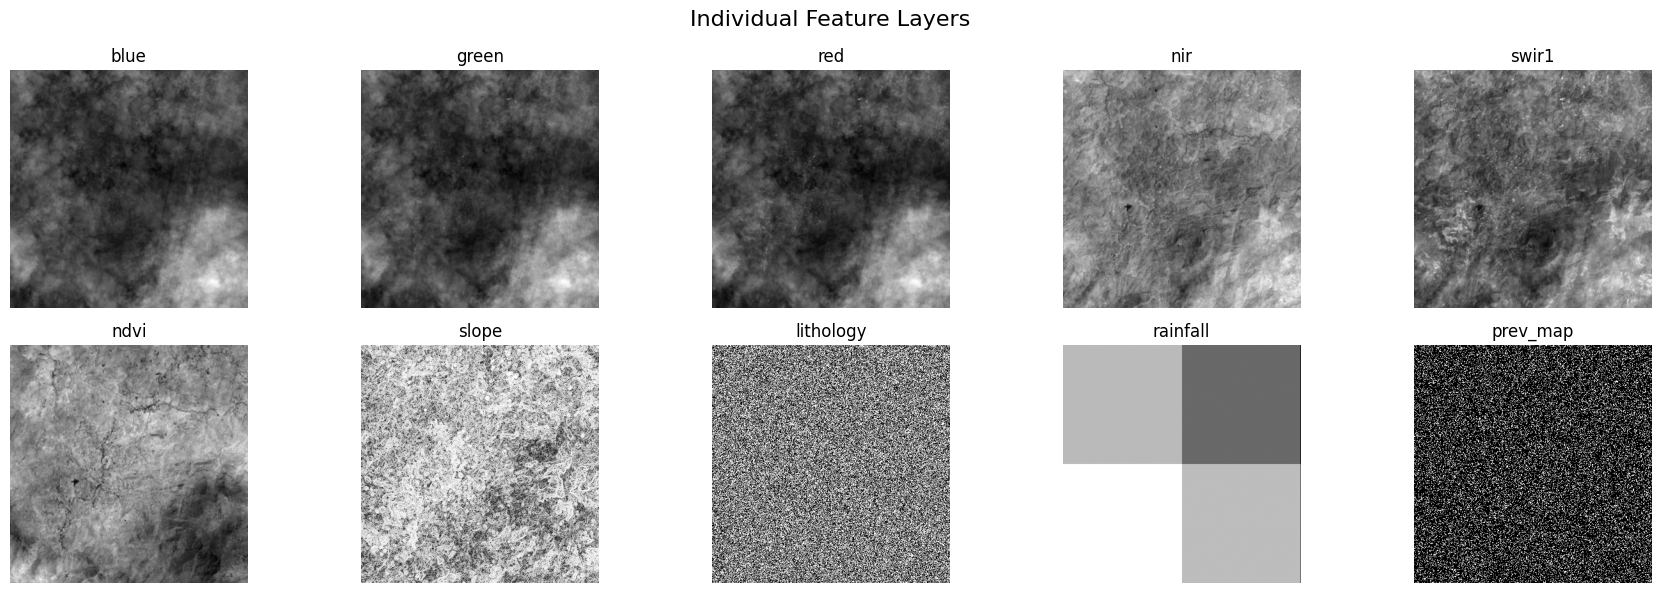

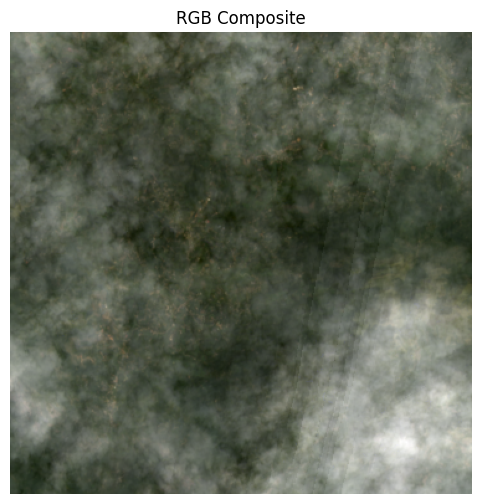

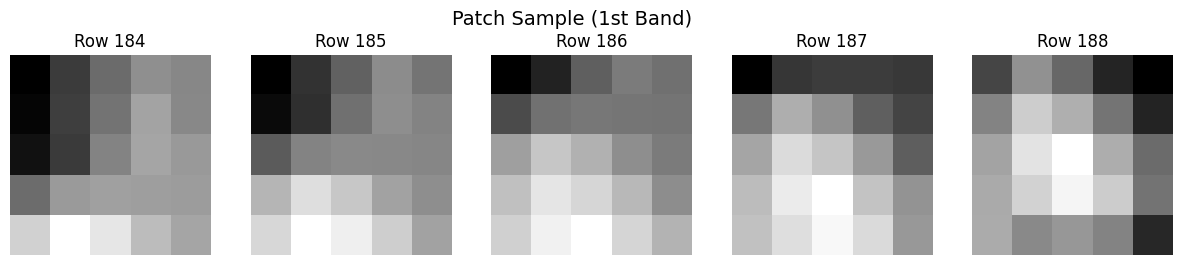

In [ ]:
import ee
import numpy as np
import rasterio
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import os
from datetime import datetime
import time

# Authenticate and Initialize Google Earth Engine
ee.Authenticate()
try:
    ee.Initialize()
except Exception as e:
    print(f"Error initializing GEE: {e}")
    print("Run 'earthengine authenticate' and follow the prompts.")
    exit()

# Define study area: Western Ghats near Wayanad, Kerala (10km x 10km)
region = ee.Geometry.Rectangle([76.0, 11.5, 76.1, 11.6])
resolution = 30  # 30m resolution for Landsat data

# Function to mask clouds in Landsat 8 imagery using QA_PIXEL band
def mask_landsat_clouds(image):
    qa = image.select('QA_PIXEL')
    cloud_bit = 1 << 3  # Bit 3 for cloud
    cloud_shadow_bit = 1 << 4  # Bit 4 for cloud shadow
    mask = qa.bitwiseAnd(cloud_bit).eq(0).And(qa.bitwiseAnd(cloud_shadow_bit).eq(0))
    return image.updateMask(mask)

# Function to download raster data, handling both Image and ImageCollection
def download_raster(collection, bands, start_date, end_date, region, scale, output_path, is_image=False, apply_cloud_mask=False):
    if is_image:
        print(f"Processing {collection} as a static Image (not a collection).")
        image = ee.Image(collection)
        if isinstance(bands, list):
            image = image.select(bands)
        else:
            image = image.select(bands)
        image = image.clip(region)
    else:
        print(f"Processing {collection} as an ImageCollection with time range {start_date} to {end_date}.")
        image_coll = (ee.ImageCollection(collection)
                      .filterBounds(region)
                      .filterDate(start_date, end_date))
        if apply_cloud_mask:
            image_coll = image_coll.map(mask_landsat_clouds)
        image = image_coll.mean()
        if isinstance(bands, list):
            image = image.select(bands)
        else:
            image = image.select(bands)
        image = image.clip(region)
    
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=os.path.basename(output_path),
        folder='landslide_data',
        region=region,
        scale=scale,
        fileFormat='GeoTIFF'
    )
    task.start()
    print(f"Export task started for {output_path}...")
    return task

# Set data directory to the specified path (mapped in WSL)
data_dir = '/mnt/c/Users/ASUS/Desktop/landslide4sense trail/pred_map/landslide_data'
os.makedirs(data_dir, exist_ok=True)
print(f"Using data directory: {data_dir}")

# Download multispectral bands and other data for 2021-2023 with cloud masking
start_date = '2011-01-01'
end_date = '2023-12-31'  # Three-year dataset
landsat_bands = {
    'SR_B2': 'blue.tif',  # Blue
    'SR_B3': 'green.tif', # Green
    'SR_B4': 'red.tif',   # Red
    'SR_B5': 'nir.tif',   # NIR
    'SR_B6': 'swir1.tif'  # SWIR1
}
tasks = []
for band, filename in landsat_bands.items():
    task = download_raster('LANDSAT/LC08/C02/T1_L2', band, start_date, end_date, region, resolution, os.path.join(data_dir, filename), is_image=False, apply_cloud_mask=True)
    tasks.append((task, filename))

# Download DEM (SRTM) as a static image
task = download_raster('USGS/SRTMGL1_003', 'elevation', start_date, end_date, region, resolution, os.path.join(data_dir, 'elevation.tif'), is_image=True)
tasks.append((task, 'elevation.tif'))

# Download rainfall data (CHIRPS) for three years
task = download_raster('UCSB-CHG/CHIRPS/DAILY', 'precipitation', start_date, end_date, region, resolution, os.path.join(data_dir, 'rainfall.tif'), is_image=False)
tasks.append((task, 'rainfall.tif'))

# Manual pause to ensure files are downloaded from Google Drive
print("\nIMPORTANT: GEE export tasks have been started. Please follow these steps:")
print("1. Go to https://code.earthengine.google.com/ and check the 'Tasks' tab for export completion.")
print("2. Once tasks are completed, download all GeoTIFF files from Google Drive's 'landslide_data' folder.")
print("3. Place the files in the specified directory:", os.path.abspath(data_dir))
print("Files needed: blue.tif, green.tif, red.tif, nir.tif, swir1.tif, elevation.tif, rainfall.tif")
input("Press Enter to continue after downloading and placing all files in the specified folder...")

# Verify that all files exist before proceeding
required_files = ['blue.tif', 'green.tif', 'red.tif', 'nir.tif', 'swir1.tif', 'elevation.tif', 'rainfall.tif']
missing_files = []
for file in required_files:
    if not os.path.exists(os.path.join(data_dir, file)):
        missing_files.append(file)

if missing_files:
    print(f"Error: The following files are missing in {data_dir}: {', '.join(missing_files)}")
    print("Please download them from Google Drive and place them in the correct folder before proceeding.")
    exit(1)
else:
    print("All required files are present. Proceeding with processing...")

# Load all rasters with error handling and shape checking
rasters = {}
try:
    for key in ['blue', 'green', 'red', 'nir', 'swir1', 'elevation', 'rainfall']:
        rasters[key] = rasterio.open(os.path.join(data_dir, f"{key}.tif")).read(1)
except rasterio.errors.RasterioIOError as e:
    print(f"Error: Could not load raster files. {e}")
    print("Ensure all required GeoTIFF files are downloaded correctly.")
    exit(1)

# Check shapes of loaded rasters and set reference shape
reference_shape = None
for key, raster in rasters.items():
    if reference_shape is None:
        reference_shape = raster.shape
        print(f"Reference shape set to {reference_shape} from {key}.tif")
    elif raster.shape != reference_shape:
        print(f"Shape mismatch: {key}.tif has shape {raster.shape}, expected {reference_shape}")
        print(f"Warning: Shape mismatch detected. Manual alignment needed or adjust script for resampling.")
        exit(1)
    else:
        print(f"Shape match: {key}.tif has shape {raster.shape}")

# Since shapes are verified, proceed with derived rasters
# Calculate NDVI locally with error handling
def calculate_ndvi(nir_path, red_path, output_path):
    try:
        with rasterio.open(nir_path) as nir, rasterio.open(red_path) as red:
            nir_band = nir.read(1).astype(float)
            red_band = red.read(1).astype(float)
            np.seterr(divide='ignore', invalid='ignore')
            ndvi = (nir_band - red_band) / (nir_band + red_band)
            ndvi = np.nan_to_num(ndvi, nan=0.0)
            with rasterio.open(output_path, 'w', driver='GTiff', height=nir.height, width=nir.width, count=1, dtype='float32', crs=nir.crs, transform=nir.transform) as dst:
                dst.write(ndvi, 1)
        return ndvi
    except rasterio.errors.RasterioIOError as e:
        print(f"Error: Could not open input files for NDVI calculation. {e}")
        print(f"Ensure {nir_path} and {red_path} are downloaded correctly.")
        exit(1)

ndvi = calculate_ndvi(os.path.join(data_dir, 'nir.tif'), os.path.join(data_dir, 'red.tif'), os.path.join(data_dir, 'ndvi.tif'))

# Calculate slope locally from elevation with error handling
def calculate_slope(elevation_path, output_path):
    try:
        with rasterio.open(elevation_path) as src:
            elevation = src.read(1)
            dx, dy = np.gradient(elevation, resolution)
            slope = np.degrees(np.arctan(np.sqrt(dx**2 + dy**2)))
            with rasterio.open(output_path, 'w', driver='GTiff', height=src.height, width=src.width, count=1, dtype='float32', crs=src.crs, transform=src.transform) as dst:
                dst.write(slope, 1)
        return slope
    except rasterio.errors.RasterioIOError as e:
        print(f"Error: Could not open elevation file for slope calculation. {e}")
        print(f"Ensure {elevation_path} is downloaded correctly.")
        exit(1)

slope = calculate_slope(os.path.join(data_dir, 'elevation.tif'), os.path.join(data_dir, 'slope.tif'))

# Load derived rasters
try:
    rasters['ndvi'] = rasterio.open(os.path.join(data_dir, 'ndvi.tif')).read(1)
    rasters['slope'] = rasterio.open(os.path.join(data_dir, 'slope.tif')).read(1)
except rasterio.errors.RasterioIOError as e:
    print(f"Error: Could not load derived raster files. {e}")
    print("Ensure derived files are created correctly.")
    exit(1)

# Verify shapes for derived rasters
for key, raster in rasters.items():
    if raster.shape != reference_shape:
        print(f"Shape mismatch after derived rasters: {key} has shape {raster.shape}, expected {reference_shape}")
        print(f"Warning: Shape mismatch detected. Manual alignment needed or adjust script for resampling.")
        exit(1)
    else:
        print(f"Shape match: {key} has shape {raster.shape}")

# Create synthetic lithology and previous landslide map with dynamic shape based on reference
np.random.seed(42)
height, width = reference_shape  # Use reference shape from GEE rasters
synthetic_lithology = np.random.randint(1, 5, (height, width))
synthetic_prev_map = np.random.choice([0, 1], size=(height, width), p=[0.8, 0.2])
with rasterio.open(os.path.join(data_dir, 'lithology.tif'), 'w', driver='GTiff', height=height, width=width, count=1, dtype='int32', crs='EPSG:4326', transform=rasterio.transform.from_bounds(76.0, 11.5, 76.1, 11.6, width, height)) as dst:
    dst.write(synthetic_lithology, 1)
with rasterio.open(os.path.join(data_dir, 'prev_map.tif'), 'w', driver='GTiff', height=height, width=width, count=1, dtype='int32', crs='EPSG:4326', transform=rasterio.transform.from_bounds(76.0, 11.5, 76.1, 11.6, width, height)) as dst:
    dst.write(synthetic_prev_map, 1)

# Load synthetic data into rasters dictionary
try:
    rasters['lithology'] = rasterio.open(os.path.join(data_dir, 'lithology.tif')).read(1)
    rasters['prev_map'] = rasterio.open(os.path.join(data_dir, 'prev_map.tif')).read(1)
except rasterio.errors.RasterioIOError as e:
    print(f"Error: Could not load synthetic raster files. {e}")
    print("Ensure synthetic files are created correctly.")
    exit(1)

# Verify shapes for synthetic rasters
for key, raster in rasters.items():
    if raster.shape != reference_shape:
        print(f"Shape mismatch for synthetic rasters: {key} has shape {raster.shape}, expected {reference_shape}")
        print(f"Warning: Shape mismatch detected. Manual alignment needed or adjust script for resampling.")
        exit(1)
    else:
        print(f"Shape match: {key} has shape {raster.shape}")



def visualize_feature_stack(rasters, patch_size=5, show_patch=True, show_rgb=True):
    import matplotlib.pyplot as plt

    # Define some features to display
    feature_keys = ['blue', 'green', 'red', 'nir', 'swir1', 'ndvi', 'slope', 'lithology', 'rainfall','prev_map']
    n_features = len(feature_keys)

    # Plot each feature band
    fig, axes = plt.subplots(2, (n_features + 1) // 2, figsize=(18, 6))
    fig.suptitle("Individual Feature Layers", fontsize=16)

    for ax, key in zip(axes.flat, feature_keys):
        img = rasters[key]
        ax.imshow(img, cmap='gray')
        ax.set_title(key)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    # Optional: RGB composite using red, green, blue
    if show_rgb and all(k in rasters for k in ['red', 'green', 'blue']):
        rgb = np.stack([
            rasters['red'],
            rasters['green'],
            rasters['blue']
        ], axis=-1)
        rgb_norm = (rgb - rgb.min()) / (rgb.max() - rgb.min())  # Normalize
        plt.figure(figsize=(6, 6))
        plt.imshow(rgb_norm)
        plt.title("RGB Composite")
        plt.axis('off')
        plt.show()

    # Optional: Show example patch (center of image)
    if show_patch:
        h, w = rasters['ndvi'].shape
        i, j = h // 2, w // 2
        half = patch_size // 2
        fig, axes = plt.subplots(1, patch_size, figsize=(15, 3))
        for k in range(patch_size):
            i_idx = i - half + k
            patch_row = []
            for key in feature_keys:
                band = rasters[key]
                patch = band[i_idx-half:i_idx+half+1, j-half:j+half+1]
                patch_row.append(patch)
            stacked_patch = np.stack(patch_row, axis=-1)
            axes[k].imshow(stacked_patch[:, :, 0], cmap='gray')  # Show first band as preview
            axes[k].set_title(f"Row {i_idx}")
            axes[k].axis('off')
        plt.suptitle("Patch Sample (1st Band)", fontsize=14)
        plt.show()



visualize_feature_stack(rasters)

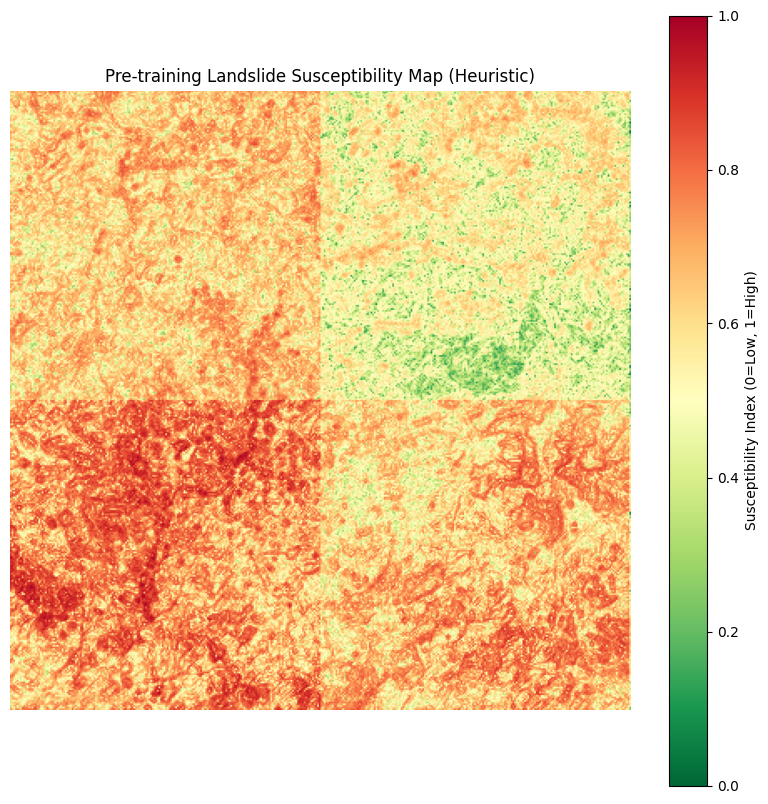

/home/pranav90/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 5, 5, 32)       │         2,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 5, 5, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 5, 5, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 5, 5, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 2, 2, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 1, 1, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 1, 1, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 425,377 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/35
3460/3460 ━━━━━━━━━━━━━━━━━━━━ 44s 11ms/step - accuracy: 0.7843 - loss: 0.5485 - val_accuracy: 0.8012 - val_loss: 0.5007
Epoch 2/35
3460/3460 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - accuracy: 0.8002 - loss: 0.5062 - val_accuracy: 0.8012 - val_loss: 0.5003
Epoch 3/35
3460/3460 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - accuracy: 0.7984 - loss: 0.5064 - val_accuracy: 0.8012 - val_loss: 0.5008
Epoch 4/35
3460/3460 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - accuracy: 0.7976 - loss: 0.5048 - val_accuracy: 0.8012 - val_loss: 0.4997
Epoch 5/35
3460/3460 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - accuracy: 0.7987 - loss: 0.5027 - val_accuracy: 0.8012 - val_loss: 0.4988
Epoch 6/35
3460/3460 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - accuracy: 0.7979 - loss: 0.5034 - val_accuracy: 0.8012 - val_loss: 0.4988
Epoch 7/35
3460/3460 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - accuracy: 0.7999 - loss: 0.5006 - val_accuracy: 0.8012 - val_loss: 0.4988
Epoch 8/35
3460/3460 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - accuracy: 0.7993 - loss: 

In [ ]:
def generate_pretraining_susceptibility_map(rasters, output_path=None, show=True):
    """
    Create a heuristic-based landslide susceptibility map using raw features before model training.
    
    rasters: dict containing raw feature arrays, keys must include: 'slope', 'rainfall', 'ndvi', 'lithology'
    output_path: optional file path to save PNG
    show: if True, displays the plot inline
    """
    slope = rasters['slope'].astype(float)
    rainfall = rasters['rainfall'].astype(float)
    ndvi = rasters['ndvi'].astype(float)
    lithology = rasters['lithology'].astype(int)

    # Normalize continuous variables (0–1)
    slope_norm = (slope - slope.min()) / (slope.max() - slope.min())
    rainfall_norm = (rainfall - rainfall.min()) / (rainfall.max() - rainfall.min())
    ndvi_norm = (ndvi - ndvi.min()) / (ndvi.max() - ndvi.min())

    # Invert NDVI (low vegetation = high susceptibility)
    inv_ndvi = 1.0 - ndvi_norm

    # Lithology scoring (example: user-defined risk per class)
    lithology_score = np.zeros_like(lithology, dtype=float)
    lithology_weights = {
        1: 0.6,  # e.g., hard rock = low risk
        2: 0.7,
        3: 0.9,
        4: 1.0   # e.g., weak soil = high risk
    }
    for val, score in lithology_weights.items():
        lithology_score[lithology == val] = score

    # Combine all into a simple susceptibility index (weighted sum)
    susceptibility = (
        0.4 * slope_norm +
        0.3 * rainfall_norm +
        0.2 * inv_ndvi +
        0.1 * lithology_score
    )

    # Normalize the final result to 0–1
    susceptibility = (susceptibility - susceptibility.min()) / (susceptibility.max() - susceptibility.min())

    # Plot the map
    plt.figure(figsize=(10, 10))
    cmap = plt.cm.RdYlGn_r  # Red = high risk
    im = plt.imshow(susceptibility, cmap=cmap, vmin=0, vmax=1)
    plt.colorbar(im, label='Susceptibility Index (0=Low, 1=High)')
    plt.title('Pre-training Landslide Susceptibility Map (Heuristic)')
    plt.axis('off')

    if output_path:
        plt.savefig(output_path, bbox_inches='tight', dpi=300)
    if show:
        plt.show()
    else:
        plt.close()

    return susceptibility

heuristic_map = generate_pretraining_susceptibility_map(rasters, output_path='heuristic_susceptibility.png')


# Prepare data for CNN with spatial patches
patch_size = 5  # 5x5 patches
half_patch = patch_size // 2
height, width = rasters['ndvi'].shape
n_features = len(rasters) - 1  # Exclude prev_map (target)
X = np.zeros((height * width, patch_size, patch_size, n_features))
y = rasters['prev_map'].flatten()

feature_stack = np.stack([rasters[key] for key in rasters if key != 'prev_map'], axis=-1)
idx = 0
for i in range(height):
    for j in range(width):
        i_start = max(0, i - half_patch)
        i_end = min(height, i + half_patch + 1)
        j_start = max(0, j - half_patch)
        j_end = min(width, j + half_patch + 1)
        patch = feature_stack[i_start:i_end, j_start:j_end, :]
        pad_i = half_patch - (i - i_start)
        pad_i_end = half_patch + 1 + (i_end - i - 1)
        pad_j = half_patch - (j - j_start)
        pad_j_end = half_patch + 1 + (j_end - j - 1)
        padded_patch = np.zeros((patch_size, patch_size, n_features))
        padded_patch[pad_i:pad_i_end, pad_j:pad_j_end, :] = patch
        X[idx] = padded_patch
        idx += 1

# Normalize features
scaler = StandardScaler()
X_reshaped = X.reshape(-1, n_features)
X_reshaped = scaler.fit_transform(X_reshaped)
X = X_reshaped.reshape(X.shape)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build optimized CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(patch_size, patch_size, n_features), padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train model
history = model.fit(X_train, y_train, epochs=35, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Predict susceptibility for entire area
predictions = model.predict(X).reshape(height, width)

In [ ]:
# Create color-coded map
plt.figure(figsize=(10, 10))
cmap = plt.cm.RdYlGn_r
plt.imshow(predictions, cmap=cmap, vmin=0, vmax=1)
plt.colorbar(label='Landslide Susceptibility (0=Low, 1=High)')
plt.title('Baseline Landslide Susceptibility Map for Western Ghats, Kerala (Next Few Years)')
plt.savefig('landslide_susceptibility_map_kerala.png')
plt.close()

# Save model
model.save('landslide_model_kerala.h5')

# Clean up temporary files
#try:
#   for file in os.listdir(data_dir):
#      os.remove(os.path.join(data_dir, file))
#        os.rmdir(data_dir)
#except Exception as e:
#    print(f"Error cleaning up temporary files: {e}")

print("Model and map saved. Check 'landslide_model_kerala.h5' and 'landslide_susceptibility_map_kerala.png'.")

Model and map saved. Check 'landslide_model_kerala.h5' and 'landslide_susceptibility_map_kerala.png'.


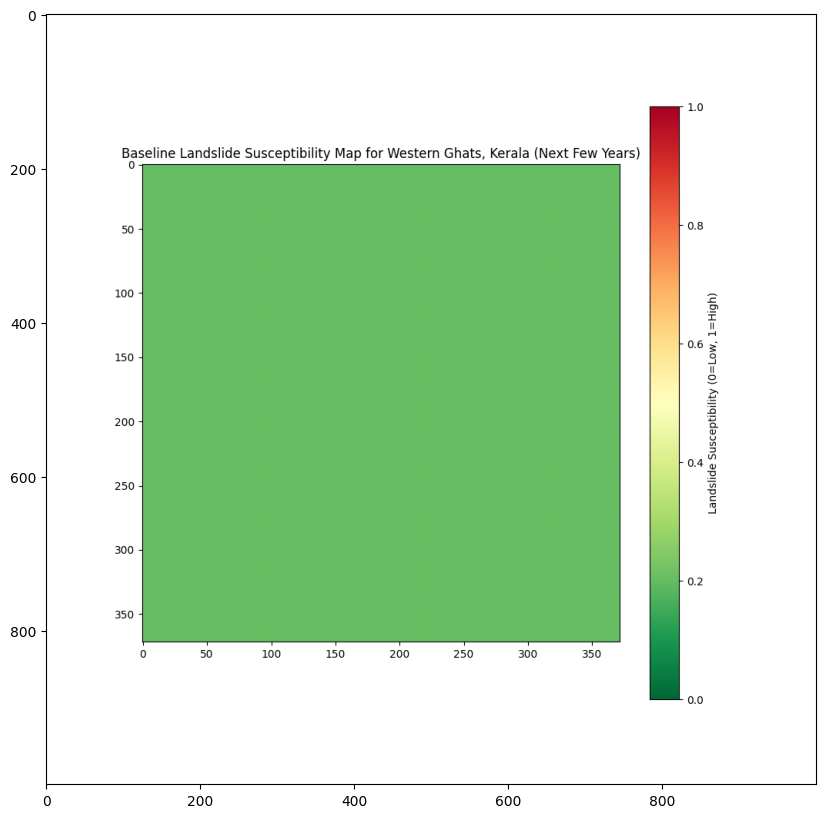

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('landslide_susceptibility_map_kerala.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)